# Задача языкового моделирования

Студента отчислили за...

АКОС 0.5

Алгосы 0.2

Теорвер 0.3 $= P(\text{теорвер} | \text{за}, \text{отчислили}, \text{студента})$

$$P(w_0, \dots, w_n) = \Pi_{i=0}^nP(w_i|w_{i-1}, \dots, w_0)$$
$$\log P(w_0, \dots, w_n)= \log \Pi_{i=0}^nP(w_i|w_{i-1}, \dots, w_0) =∑_{i=0}^n \log P(w_i|w_{i-1}, \dots, w_0) $$
$$PP(w)=\sqrt[n]{\frac{1}{ \Pi_{i=0}^nP(w_i|w_{i-1}, \dots, w_0)}}=\exp \left(-\frac{1}{n}∑_{i=0}^n \log P(w_i|w_{i-1}, \dots, w_0) \right)$$

чем ниже перплексия, тем лучше

N-граммы - последовательности токенов длины N

N=1: униграммы

N=2: биграммы

N=3: триграммы

Замечание: обычно используется $N \leq 5$

GREEDY - на каждом шаге выбираем наиболее вероятный токен

$O(n)$

BEAM Search - на каждом шаге выбираем $k$ наиболее вероятных вариантов

$O(kn)$

**Студент 0.3**

**Студентка 0.3**

Преподаватель 0.2

Администрация 0.2

**Студент**

**отчислен** 0.5

переведен 0.3

взял 0.2

**Студентка**

**отчислена** 0.5

переведена 0.3

взяла 0.2

**Студент отчислен за**

**АКОС** 0.5

**Алгосы** 0.5

Студентка отчислена за

АКОС 0.3

Алгосы 0.3

Теорвер 0.4

Проблемы:

- затухающие градиенты
- взрывающиеся градиенты (gradient clipping)

Long Short Term Memory (LSTM)

+ память


Gated Recurrent Units

In [35]:
!pip install datasets

In [36]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')



In [37]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [39]:
dataset = load_dataset('IlyaGusev/gazeta', revision='v1.0', trust_remote_code=True)

In [40]:
sents = []
for sent in tqdm(dataset['validation']['text']):
  sents.extend(
      [x.lower() for x in sent_tokenize(sent, language='russian') if len(x) < 256]
  )

  0%|          | 0/5265 [00:00<?, ?it/s]

In [41]:
len(sents)

191894

In [42]:
print(sents[666])

когда мужчина подошел к подсобному помещению, за ним проследовал злоумышленник в шлеме мотоциклиста.


In [43]:
chars = Counter()

In [44]:
for sent in tqdm(sents):
  for c in sent:
    chars[c] += 1

  0%|          | 0/191894 [00:00<?, ?it/s]

In [45]:
len(chars)

153

In [46]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
cnt_threshold = 666

for c, cnt in chars.items():
  if cnt > cnt_threshold:
    vocab.add(c)

In [47]:
len(vocab)

89

In [48]:
c2id = {c : i for i, c in enumerate(vocab)}
id2c = {i : c for c, i in c2id.items()}

In [49]:
class CDataset:
  def __init__(self, sent):
    self.data = sent
    self.unk_id = c2id['<unk>']
    self.bos_id = c2id['<bos>']
    self.eos_id = c2id['<eos>']
    self.pad_id = c2id['<pad>']

  def __getitem__(self, idx):
    token_s = [self.bos_id]
    token_s += [c2id.get(c, self.unk_id) for c in self.data[idx]]
    token_s += [self.eos_id]

    return token_s


  def __len__(self):
    return len(self.data)

In [50]:
def trans_func(input_batch, pad_id=c2id['<pad>']):
    # print('***', input_batch)
    s_lens = [len(x) for x in input_batch]
    max_s_len = max(s_lens)
    new_batch = []
    for s in input_batch:
        for _ in range(max_s_len - len(s)):
          s.append(pad_id)
        new_batch.append(s)
    
    sq = torch.LongTensor(new_batch).to(device)
    new_batch = {
      'in_ids': sq[:, :-1],
      'target_ids': sq[:, 1:]
    }
    return new_batch

In [54]:
b1 = [[28, 54, 66, 86, 52, 38, 66,], [86, 45, 86, 25, 14, 86]]
b2 = [[1, 2], [5]]
print('b1 ->', trans_func(b1)['target_ids'].flatten())
print()
print('b2 ->', trans_func(b2))

b1 -> tensor([54, 66, 86, 52, 38, 66, 45, 86, 25, 14, 86, 74], device='cuda:0')

b2 -> {'in_ids': tensor([[1],
        [5]], device='cuda:0'), 'target_ids': tensor([[ 2],
        [74]], device='cuda:0')}


Мама мыла раму

in: "мама мыла раму<pad>"

target: "ама мыла раму<pad><pad>"

In [18]:
sents = sents[:5]
train_s, eval_s = train_test_split(sents, test_size=0.2)

In [19]:
train_dataset = CDataset(train_s)
eval_dataset = CDataset(eval_s)

In [20]:
train_dataset.data[0]

'тепень за оборонительные действия в «спартаке» отвечают роман зобнин и аяз гулиев , однако их игра вызывает больше негативных оценок, нежели уверенности за результат.'

In [21]:
len(train_dataset), len(train_s)

(4, 4)

In [60]:
train_dataloader = DataLoader(
    train_dataset, collate_fn=trans_func, batch_size=512
)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=trans_func, batch_size=512
)

In [61]:
train_dataloader

In [62]:
class CLM(nn.Module):
  def __init__(self, hidden_dim, vocab_size):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, hidden_dim)
    self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
    self.linear = nn.Linear(hidden_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, vocab_size)

    self.non_lin = nn.Tanh()
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, input_batch):
    embeddings = self.embedding(input_batch) # batch_sz, sq_len, hidden_dim
    out, _ = self.rnn(embeddings) # batch_sz, sq_len, hidden_dim
    out = self.dropout(self.linear(self.non_lin(out))) # batch_sz, sq_len, hidden_dim
    res = self.linear2(self.non_lin(out)) # batch_sz, sq_len, vocab_size

    return res

In [63]:
def evaluate(model, crit):
  model.eval()
  perplexity = []
  with torch.no_grad():
    for batch in eval_dataloader:
      logs = model(batch['in_ids']).flatten(start_dim=0, end_dim=1)
      loss = crit(
          logs,
          batch['target_ids'].flatten()
      )
      perplexity.append(torch.exp(loss).item())
  perplexity = sum(perplexity) / len(perplexity)

  return perplexity

In [64]:
model = CLM(hidden_dim=512, vocab_size=len(vocab)).to(device)

In [65]:
in1 = torch.tensor([[28, 54, 66, 86, 52, 38],
        [86, 45, 86, 25, 14, 86]], device='cuda:0')
in2 = torch.tensor([[1],        [5]], device='cuda:0')

In [66]:
model(in1).shape

torch.Size([2, 6, 89])

In [67]:
model(in1).flatten(start_dim=0, end_dim=1).shape

torch.Size([12, 89])

In [68]:
crit = nn.CrossEntropyLoss(ignore_index=c2id['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [72]:
num_ep = 3
losses = []
perplexities = []

for ep in range(num_ep):
  ep_losses = []
  model.train()
  for batch in tqdm(train_dataloader, desc=f'Training ep {ep}:'):
    optimizer.zero_grad()
    logs = model(batch['in_ids']).flatten(start_dim=0, end_dim=1)
    loss = crit(
        logs, batch['target_ids'].flatten()
    )
    loss.backward()
    optimizer.step()

    ep_losses.append(loss.item())

  losses.append(sum(ep_losses) / len(ep_losses))
  perplexities.append(evaluate(model, crit))

Training ep 0::   0%|          | 0/1 [00:00<?, ?it/s]

Training ep 1::   0%|          | 0/1 [00:00<?, ?it/s]

Training ep 2::   0%|          | 0/1 [00:00<?, ?it/s]

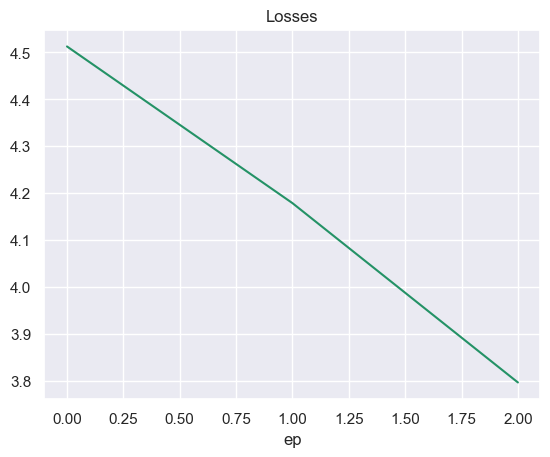

In [70]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel('ep')
plt.show()

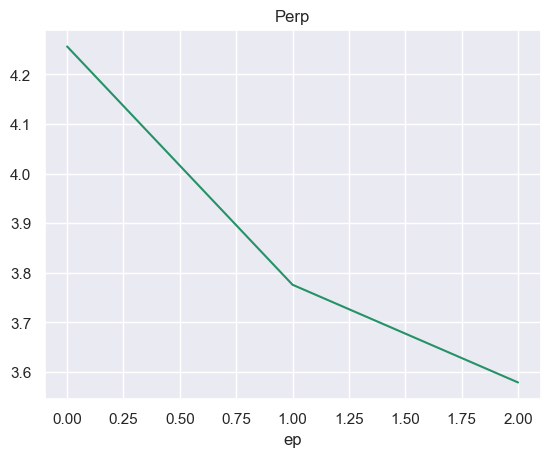

In [30]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title("Perp")
plt.xlabel('ep')
plt.show()

In [31]:
def generate(model, start_s, max_s_len):
  device = 'cpu'
  model.to(device)
  input_ids = [c2id['<bos>']] + [c2id.get(c, c2id['<unk>']) for c in start_s]
  input_ids = torch.LongTensor(input_ids).to(device)

  model.eval()
  with torch.no_grad():
    for i in range(max_s_len):
      next_c_dist = model(input_ids)[-1]
      next_c = next_c_dist.squeeze().argmax()
      input_ids = torch.cat([input_ids, next_c.unsqueeze(0)])

      if next_c.item() == c2id['<eos>']:
        break
  words = ''.join([id2c[id_.item()] for id_ in input_ids])
  return words

In [32]:
generate(model, start_s='потерпевший', max_s_len=128)

'<bos>потерпевший в своем твиттере поставили в своем твиттере.<eos>'

1960-2010 Донейросетая эпоха

2013 Vord2Vec

2014 Seq2Seq RNN

2017 Transformers

2018 BERT, GPT

2019 GPT-3, Megatron-LM

2023 GPT-4

## Byte-pair-encoding

алфавит из одиночных символов; вш; вшэ; ма; па

In [33]:
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='summer')

In [34]:
!pip install datasets

In [35]:
!pip install transformers

In [36]:
!pip install evaluate

In [37]:
from transformers import (
    BertForSequenceClassification,
    BertTokenizerFast,
    DataCollatorWithPadding,
    get_scheduler
)

import datasets
import evaluate

In [38]:
device = 'cuda' if torch.cuda.is_available() else False
device

'cuda'

In [39]:
data = datasets.load_dataset('glue', 'rte')
metric = evaluate.load('glue', 'rte')

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [40]:
data

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 2490
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 277
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3000
    })
})

In [41]:
metric

EvaluationModule(name: "glue", module_type: "metric", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = evaluate.load('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=ref

In [42]:
model_name = 'bert-base-uncased'

In [43]:
tokenizer = BertTokenizerFast.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

d:\Alex_Karachun\DEV\neuroPushkin-nlp_project\.venv\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pavel\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [44]:
def get_token(text):
  res = tokenizer(
      text['sentence1'], text['sentence2'],
      padding=False, max_length=512, truncation=True)
  if "label" in text:
    res["labels"] = text["label"]
  return res

In [45]:
ready_data = data.map(
    get_token,
    remove_columns=data["train"].column_names
)

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [46]:
data_collator = DataCollatorWithPadding(tokenizer)

In [47]:
batch_size = 64

train_dataloader = DataLoader(
    ready_data['train'],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size
)

eval_dataloader = DataLoader(
    ready_data['validation'],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=batch_size
)

In [48]:
model = BertForSequenceClassification.from_pretrained(model_name).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [49]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [50]:
num_ep = 5

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=len(train_dataloader) // 2,
    num_training_steps=len(train_dataloader) * num_ep,
)

In [51]:
eval_losses = []
train_losses = []
eval_metr = []
learn_rate = []

for ep in range(num_ep):
  model.train()
  curr_train_loss = []
  for i, batch in enumerate(
      tqdm(train_dataloader, desc=f'Train ep {ep}')):
      batch = {k : v.to(device) for k, v in batch.items()}
      out = model(**batch)
      loss = out.loss

      loss.backward()
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()

      curr_train_loss.append(loss.item())
      learn_rate.append(lr_scheduler.get_last_lr())
  train_losses.append(sum(curr_train_loss) / len(curr_train_loss))

  model.eval()
  curr_eval_loss = []
  for i, batch in enumerate(eval_dataloader):
    batch = {k : v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      out = model(**batch)
    predict = out.logits.argmax(dim=-1)

    metric.add_batch(
        predictions=predict,
        references=batch['labels'],
    )

    curr_eval_loss.append(out.loss.item())

  eval_metric = metric.compute()
  eval_metr.append(eval_metric['accuracy'])
  eval_losses.append(sum(curr_eval_loss) / len(curr_eval_loss))

Train ep 0:   0%|          | 0/39 [00:00<?, ?it/s]

d:\Alex_Karachun\DEV\neuroPushkin-nlp_project\.venv\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Train ep 1:   0%|          | 0/39 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(len(train_losses)), train_losses, color='red', label='train')
plt.plot(np.arange(len(eval_losses)), eval_losses, label='eval', color='blue')
plt.title('Losses')
plt.xlabel('ep')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.arange(len(eval_metr)), eval_metr)
plt.title('Accuracy')
plt.xlabel('ep')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.arange(len(learn_rate)), learn_rate)
plt.title('Learning rate')
plt.xlabel('steps')
plt.legend()
plt.show()

In [ ]:
def f(x, a=[1, 2, 3]):
  a.append(x)
  print(*a)

In [ ]:
f(1)
f(2)

In [ ]:
a = [1, 3, 3]
b = a
b.append(1)
print(a)